# ECE 5470 Lab 7 Report

#### by Cynthia Li

## Part A Section 1 Data Set Creation

#### idata Creation
After I have followed the instructions to craft 60 handwritten characters including 5 different copies of 0-9 and 10 symbols, I want to first test the preprocessing effect on a single image. The naming of the charaters are as p$i.jpg, $i as the index of the characters (the five copies of each 0-9 then the symbols) starting from 1. 

First, I want to create a gray scale copy of the image in vx format. In this case, I ran the following code:

##### vfmt -g if=p1.jpg of=p1.vx

Then for display purpose, we used vxport to convert the image to png format:

##### vxport -png if=p1.vx of=p1.png

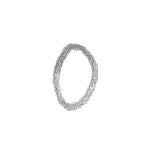

Original character in grey scale


In [1]:
from PIL import Image
from v4 import vx
from v4 import vd
display(Image.open("./handwritten/p1.png"))
print("Original character in grey scale")

To reduce the bias/noise we want to threshold the image to separate the foreground from the background and create a new bilevel image.\
In this case, we used the vpix function as shown:

##### vpix if=p1.vx th=240 hi=0 lo=255 of=p1t.vx

First to notice is that we want to set the low value to 255 and high value to 0 because we want the letter itself to be white while the background to be black.\
Second is that to determine an appropriate threshold, I actually tested with several threshold values because I was using pencil to create handwritten copies, resulting in many highlight reflections in the scanned copies. A high threshold value would result in showing many white dots that doesn't actually belongs to the letter, while a low threshold value would result in holes/dots in the letter.

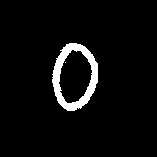

inversely thresholded character with th=240


In [2]:
display(Image.open("./handwritten/p1t.png"))
print("inversely thresholded character with th=240")

In the next step, for the convenience of future operation, we want to standardize the dataset. By standardization, I mean to make the letters in the same size (bounded by the same heigh and width without stretching) and in the center of the image. This is mainly aimed to get rid of the error resulted from the noise in the background and the bias due to different position of letter in the image.

To do so, we first want to create a tight bounding box of the character to extract the most important feature and scale it to a 20x20 square image using the following code:

##### python3 bound.py if=p1t.vx of=p1bb.vx
##### vimag if=p1bb.vx s=20,20,1 of=p1s.vx

This should help us to get rid of the bias introduced by the different size of the character. It is worth noticing that I decided to use a square box because otherwise the character will be stretched and distorted in shape when scaled to the 20x20 image. Details of bound.py code and the scaled results results are shown below. 

In [ ]:
#!/usr/bin/env python
""" bound: find the x,y coordinates that defines the tight bounding box
           of the foreground of the input bilevel image

"""
from v4 import vx
import sys
import numpy as np
import math

vargs = vx.vaparse( "if= of= -v  - ")
if '-' in vargs:
    print ("bound: tight bounding box creation program")
    print ("if= input file")
    print ("of= output file")
    print ("[-v] verbose mode")
    sys.exit(0)

for arg in ['if', 'of']:
    if arg not in vargs:
        print ('bound error: required parameter %s is missing' % arg)
        sys.exit(1)
        
optv = '-v' in vargs

ximage = vx.Vx( vargs['if'] );  # read image
tmimage = vx.Vx()

def bound (img):
    global tmimage;
    
    im = img.i
    
    # initialize bounding box coordinates for comparison
    xmin = im.shape[1]
    xmax = 0
    ymin = im.shape[0]
    ymax = 0
  
    # traverse through pixels in the image to find the tight bounding box
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (im[y, x] != 0): # for every foreground pixel
                # compare to current bounding box and update if exceeding it
                xmin = min(x, xmin)
                xmax = max(x, xmax)
                ymin = min(y, ymin)
                ymax = max(y, ymax)
    # TEST: if correct x,y coordinates of the box is obtained
    # print("xmin=", xmin, ", xmax=",  xmax, ", ymin=", ymin, ",  ymax=", ymax)
    
    bound = max(ymax-ymin+1, xmax-xmin+1)
    # copy everything in the foreground to clipped image tm
    tm = np.zeros((bound, bound), dtype='uint8')
    # TEST: if tm size is correct
    #print(tm.shape)
    #print(im.shape)

    for y in range (tm.shape[0]):
        for x in range (tm.shape[1]):
            if (y+ymin < im.shape[0] and x+xmin < im.shape[1]): # protection for im index out of bound
                tm[y, x] = im[y+ymin, x+xmin]
    # TEST: if output is correctly clipped
    # print(tm[0])
    
    # convert tm to output image
    tmimage.i = tm

bound(ximage)

if optv:
    print (tmimage.i);  # for very small images
tmimage.write(vargs['of']);  # Write the result file

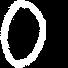

Square bounded character


Scaled 20x20 character


In [4]:
display(Image.open("./handwritten/p1bb.png"))
print("Square bounded character")
display(Image.open("./handwritten/p1s.png"))
print("Scaled 20x20 character")

From the above, we can see that the bound function can successfully produce a bounding box around the character based on the greater one between length and width.

One interesting fact was that I previous did not include the "if (y+ymin < im.shape[0] and x+xmin < im.shape[1]):" in my program, and it would report an error that the index will be out of bound for im when traversing through tm. This is because the when the higher bound of x, y in this loop is determined by the max of (ymax-ymin, xmax-xmin), so it is possible that we are in fact using  (ymax-ymin+1)+xmin or (xmax-xmin+1)+ymin, which can be out of bound. Therefore, I added in this condition for boundary protection. This wouldn't change the result because the out of boundary part is just black pixels that is not important to us. 

In the next step, as we mentioned above, we also wanted to reduce the bias introduced by the different positions of the character in the image.To do so, we want to move the bounded letter to the center of the image based on the center of mass. The details of program com.py and output result is shown below.

We will process the image by running:
##### python3 com.py if=p1s.vx of=p1com.vx

In [ ]:
#!/usr/bin/env python
""" com: place the input image to the center of a 28x28 image based
         center of mass

"""
from v4 import vx
import sys
import numpy as np
import math

vargs = vx.vaparse( "if= of= -v  - ")
if '-' in vargs:
    print ("com: center of mass reposition program")
    print ("if= input file")
    print ("of= output file")
    print ("[-v] verbose mode")
    sys.exit(0)

for arg in ['if', 'of']:
    if arg not in vargs:
        print ('com error: required parameter %s is missing' % arg)
        sys.exit(1)
        
optv = '-v' in vargs

ximage = vx.Vx( vargs['if'] );  # read image
tmimage = vx.Vx()

def com (img):
    global tmimage;
    
    im = img.i
    
    # initialize center of y and x for update
    m01 = 0 # center of y
    m10 = 0 # center of x
    m00 = np.count_nonzero(im)
  
    # traverse through pixels in the image to compute the center of mass regard to x and y
    for y in range(im.shape[0]):
        for x in range(im.shape[1]):
            if (im[y, x] != 0):
                m01 += y
                m10 += x
    comy = m01//m00
    comx = m10//m00
    
    # create a 28x28 array to store new image pixel values
    tm = np.zeros((28,28), dtype='uint8')
    
    # TEST: if tm size is correct
    # print(tm.shape)
    for y in range (tm.shape[0]):
        for x in range (tm.shape[1]):
            if (y-13+comy >= 0 and y-13+comy<20 and x-13+comx>=0 and x-13+comx<20):
                tm[y, x] = im[y-13+comy, x-13+comx]
    # TEST: if output is correctly clipped
    # print(tm[0])
    
    # convert tm to output image
    tmimage.i = tm

com(ximage)

if optv:
    print (tmimage.i);  # for very small images
tmimage.write(vargs['of']);  # Write the result file

In [5]:
display(Image.open("./handwritten/p1com.png"))
print("centered 28x28 character")

centered 28x28 character


From above, we can see that the com.py has a really nice effect on placing the extracted 20x20 image in the center of the new 28x28 image, which is our desired preprocessed result. 

In this case, we want to perform preprocessing on a volume of images, basically our 60 character dataset. To do so, I wrote a bash script to include the sequence of the steps we performed above. Note that for the convenience to perform the preprocessing on the dataset, we want to name the image in a particulart format as str+int+str.jpg, etc, with consistent content of the str part. Specific details of the bash script is shown below.

Another interesting fact is that I realized that in the terminal here we need to run the script as "bash NAME_OF_THE_BASH_SCRIPT" where in the real linux system we can simply use "./NAME_OF_THE_BASH_SCRIPT".

In [ ]:
# !/bin/sh
#
for i in {1..60..1}
do
vfmt -g if=./handwritten/p$i.jpg of=./handwritten/p$i.vx;
vpix if=./handwritten/p$i.vx th=240 hi=0 lo=255 of=./handwritten/p$(printf "%dt" "$i").vx;
python3 bound.py if=./handwritten/p$(printf "%dt" "$i").vx of=./handwritten/p$(printf "%dbb" "$i").vx;
vimag if=./handwritten/p${i}bb.vx s=20,20,1 of=./handwritten/p${i}s.vx;
python3 com.py if=./handwritten/p${i}s.vx of=./handwritten/p${i}com.vx;
vxport if=./handwritten/p${i}com.vx -png of=./idata/p${i}.png;
done

With the preprocessed result done, we also created a csv file to store the name of the results and the labels under the same folder.

#### idata2 Creation

Same as above, we create a handwritten dataset in a new folder with thickened characters. The preprocessing is pretty much the same as above but we need to add one step between thresholding and interpolation using vmorph.

Since we want to make our dataset more similar to the MNIST dataset, we want to make our lines thicker (conclusion drawn from comparing the result in idata and the MNIST). In this case, we want to perform dilation on the original image before interpolation. After many attempts of trying, there are no obvious difference between using elliptical kernel and square kernel, and I consider using a kernel size of 4x4 producing the nicest results in 28x28 image. Therefore, the following code is run on t1t.vx:

##### vmorph if=t1t.vx of=t1m.vx t=s s=4,4 -d

The results are shown below.

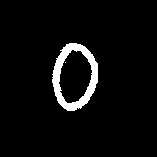

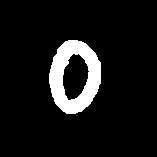

The dilated character with square kernel 7,7


resized 28x28 character


In [6]:
display(Image.open("./handwritten2/t1t.png"))
display(Image.open("./handwritten2/t1m.png"))
print("The dilated character with square kernel 7,7")
display(Image.open("./idata2/t1.png"))
print("resized 28x28 character")

Then again, we used a bash script named as preprocess2 to generate a thickened version of characters and stored the results in idata2. Details of preprocess2 are shown below. And then we created the labels in csv files for idata2.

In [ ]:
# !/bin/sh
#
for i in {1..60..1}
do
vfmt -g if=./handwritten2/t$i.jpg of=./handwritten2/t$i.vx;
vpix if=./handwritten2/t$i.vx th=240 hi=0 lo=255 of=./handwritten2/t$(printf "%dt" "$i").vx;
vmorph if=./handwritten2/t${i}t.vx of=./handwritten2/t$(printf "%dm" "$i").vx t=s s=11,11 -d;
python3 bound.py if=./handwritten2/t$(printf "%dm" "$i").vx of=./handwritten2/t$(printf "%dbb" "$i").vx;
vimag if=./handwritten2/t${i}bb.vx s=20,20,1 of=./handwritten2/t${i}s.vx;
python3 com.py if=./handwritten2/t${i}s.vx of=./handwritten2/t${i}com.vx;
vxport if=./handwritten2/t${i}com.vx -png of=./idata2/t${i}.png;
done

##  Part A, Section 2

In [2]:
#1 import required modules
import time
import io
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.arff import loadarff

from sklearn.datasets import get_data_home
from joblib import Memory
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from urllib.request import urlopen

#### Training On MNIST & Performance Evaluation

In [3]:
# read the NMIST dataset
memory = Memory(get_data_home())
@memory.cache()
def fetch_mnist():
    content = urlopen(
        'https://www.openml.org/data/download/52667/mnist_784.arff').read()
    data, meta = loadarff(io.StringIO(content.decode('utf8')))
    data = data.view([('pixels', '<f8', 784), ('class', '|S1')])
    return data['pixels'], data['class']
X, y = fetch_mnist()

In [4]:
# rescale the data, use the traditional train/test split

X = X / 255.

###### NEW  Refromat the the labels to be string rather than byte arrays
y_trans = []
for i in range(len(y)):
    y_trans.append(y[i].decode("utf-8"))
y = np.asarray(y_trans)

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

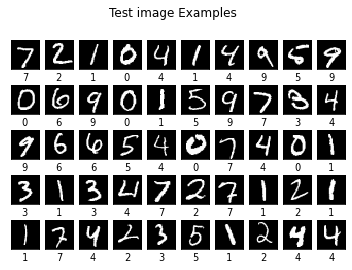

In [5]:
### Bounus 1: show the first ten images
### ALways a good idea to validate that the data appears as you expect
### 
### for sci-kit learn the images are represented as vectors of 784 elements
### currently scaled from 0 to 1

for i in range(50):
    l1_plot = plt.subplot(5, 10, i + 1)
    l1_plot.imshow(255 * X_test[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    #l1_plot.set_xlabel('Class %s' % y_test[i].decode())
    l1_plot.set_xlabel('%i' % int(y_test[i]))
plt.suptitle('Test image Examples')
plt.show()

In [6]:
## for this demonstration each pixel scale is normalized 
## by the mean and standared deviation of the training set
## note the mean and stadard deviation are set by the
## taining set only.
## why is this done?
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
#train and test classifier
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / 1000,
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1)
start_time=time.time()
#Train the classifier
clf.fit(X_train, y_train)
train_time = time.time() - start_time
start_time = time.time()
print("Training time %.3f seconds" % train_time)


#Evaluate the classifier
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

Training time 31.240 seconds
Sparsity with L1 penalty: 17.10%
Test score with L1 penalty: 0.8919


From the test score of logistic regression on MNIST as 0.8918, we can see that the overall classification is not too great but OK.

In [8]:
## For analysis show also the confusion matrix

from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test)
cfm = confusion_matrix(y_test, y_predict)
print (cfm)

[[ 952    0    1    2    0   10   11    1    3    0]
 [   0 1103    3    3    1    2    4    0   19    0]
 [  16   21  870   22   19    0   19   23   39    3]
 [   6    8   19  893    1   30    8   18   19    8]
 [   2   10    4    0  904    2   12    2    3   43]
 [  14    9    6   44   22  724   20   15   23   15]
 [  16    8    8    0   11   18  892    1    4    0]
 [   1   33   18    5   12    0    1  916    1   41]
 [  10   28    9   28   20   37    9   17  799   17]
 [  18   10    4   12   57    6    0   33    3  866]]


The confusion matrix of the trained result shows that though mostly likely the number will be recognized correctly, there are chances that the number will be classified to many of the other numbers. 

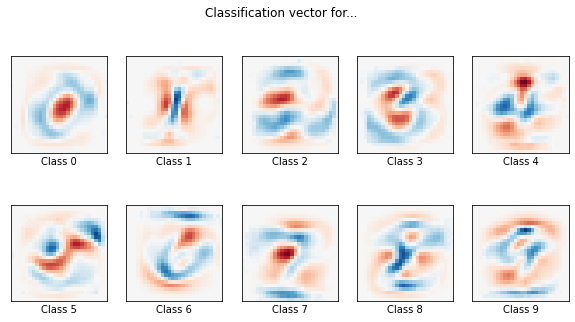

In [11]:
# Bonus 2: Visualization of the weights
# This is only possible for simple classifiers

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')
plt.show()

As we can see from the visualized classification vector, it does not necessarily look like the shape we would generally recognize for the number, this is especially true for class 4, class 5, and class 7. This is an indication of the variance of data among each class and explains why the classification may not be so great. 

In [9]:
### Bonus 3: comfusion matrix visualization tool
## A more elegant preserntation for a confusion matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization


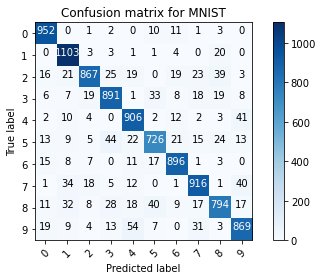

In [14]:
plot_confusion_matrix(cfm, classes=range(10), 
                      title='Confusion matrix for MNIST')

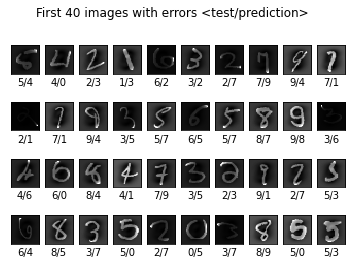

In [15]:
n=0;
i=0;
while n < 40:
    if (y_test[i]!=y_predict[i]):
        l2_plot = plt.subplot(4, 10, n + 1)
        l2_plot.imshow(255 * X_test[i].reshape(28, 28), interpolation='nearest',cmap=plt.cm.gray)
        l2_plot.set_xticks(())
        l2_plot.set_yticks(())
        l2_plot.set_xlabel('%i/%i' % (int(y_test[i]),int(y_predict[i])))
        n+=1
    i+=1
plt.suptitle('First 40 images with errors <test/prediction>')
plt.show()

As we can see from the results of first wrongly-classified 40 images in MNIST test set with test and predicted label, there are many misclassified images. In fact, in the 40 images, most numbers has about even (1/10) possibility to be misclassified to, while 8, 2 has relatively lower rate to be misclassified to and 3, 4, 7, especially 7, has a relatively higher possibility to be misclassified to. Some of which we can't really tell why directly but have to compare it to the visualized classification vector for understanding. The vector for 2 and 8 have well preserved shapes while 3, 4, 7 has been distorted from the generally recognized shape due to the variance. 

However, the overall performance was good enough and the penalty is within tolerance. 

In [10]:
""" Custom datatset loader
    based on https://github.com/utkuozbulak/pytorch-custom-dataset-examples
"""
import pandas as pd
import imageio

class SimpleDataset():
    def __init__(self, data_path, csv_name, transform = None ):
        """
        Args:
            data_path (string): path to the folder where images and csv files are located
            csv_name (string): name of the csv lablel file
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Set path
        self.data_path = data_path
        # Read the csv file
        self.data_info = pd.read_csv(data_path + csv_name, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.loc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = imageio.imread(self.data_path + single_image_name)
        
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        
        return (img_as_img, single_image_label)

    def __len__(self):
        return self.data_len

#### idata Performance Evaluation

In [18]:
mydata = SimpleDataset( "./idata/", "labels.csv")

#splitting into images and labels 
X = []
y = []
for i in range(len(mydata)):
    X.append(mydata[i][0])
    y.append((mydata[i][1]))

#converting into numpy arrays to enable easy reshaping and other array operations
    
X = np.asarray(X)
print("Shape of the input image", X.shape)
y= np.asarray(y)

Shape of the input image (60, 28, 28)


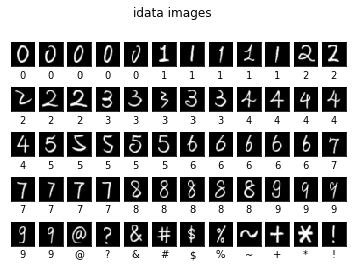

In [19]:
import warnings
warnings.filterwarnings('ignore')
for i in range(60):
    l3_plot = plt.subplot(5, 12, i + 1)
    l3_plot.imshow(X[i], interpolation='nearest',
                   cmap=plt.cm.gray)
    l3_plot.set_xticks(())
    l3_plot.set_yticks(())
    l3_plot.set_xlabel('%s' % (y[i]))
plt.suptitle('idata images')
plt.show()

In [20]:
#reshaping the array into flattened 784 array as an input for prediciton by the logistic regression classifier
X = X.reshape(X.shape[0], 784)
X = X / 255.
#data standardiation with the training set statistics is required for this clasifier
X = scaler.transform(X)

y_pred = clf.predict(X)

score = clf.score(X, y)

print("Test score with L1 penalty: %.4f" % score)
print("y_predicted_values", y_pred)
print("y_labels", y)

Test score with L1 penalty: 0.4500
y_predicted_values ['0' '0' '0' '0' '4' '1' '1' '1' '1' '1' '2' '2' '6' '2' '2' '3' '5' '5'
 '3' '5' '1' '4' '4' '4' '4' '5' '6' '5' '0' '5' '6' '6' '6' '5' '6' '7'
 '1' '1' '1' '1' '3' '3' '1' '3' '3' '3' '1' '1' '1' '1' '4' '1' '6' '4'
 '1' '1' '4' '1' '8' '1']
y_labels ['0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '3' '3' '3'
 '3' '3' '4' '4' '4' '4' '4' '5' '5' '5' '5' '5' '6' '6' '6' '6' '6' '7'
 '7' '7' '7' '7' '8' '8' '8' '8' '8' '9' '9' '9' '9' '9' '@' '?' '&' '#'
 '$' '%' '~' '+' '*' '!']


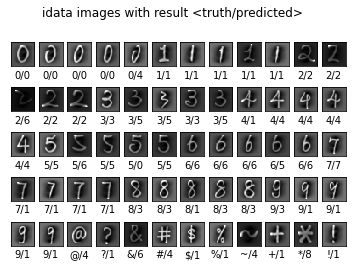

In [21]:
import warnings
warnings.filterwarnings('ignore')
for i in range(60):
    l4_plot = plt.subplot(5, 12, i + 1)
    l4_plot.imshow(X[i].reshape(28,28), interpolation='nearest',
                        cmap=plt.cm.gray)
    l4_plot.set_xticks(())
    l4_plot.set_yticks(())
    l4_plot.set_xlabel('%s/%i' % (str(y[i]),int(y_pred[i])))
plt.suptitle('idata images with result <truth/predicted>')
plt.show()

The model did not do very well on our data as the test score is only 0.45.\
One of the reason is that since the MNIST set can only classify inputs to numbers, the last 10 characters will for sure be misclassified.\
Also, because 3 and 7 is not well trained as we discussed about the classification vector, high errors in these two classes are expected as well. Moreover, because 3's model is not well trained (it is pretty close to 8), it misclassified many of the 8 in our dataset to 3 as well. It seems like the it will likely to misclassify 9 as well. This is also shown in the MNIST test.\
However, the results for 0, 1, 2, 4, 6, is pretty nice.

#### idata2 Performance Evaluation

In [23]:
mydata2 = SimpleDataset( "./idata2/", "labels.csv")

#splitting into images and labels 
X2 = []
y2 = []
for i in range(len(mydata2)):
    X2.append(mydata2[i][0])
    y2.append((mydata2[i][1]))

#converting into numpy arrays to enable easy reshaping and other array operations
    
X2 = np.asarray(X2)
print("Shape of the input image", X2.shape)
y2= np.asarray(y2)

Shape of the input image (60, 28, 28)


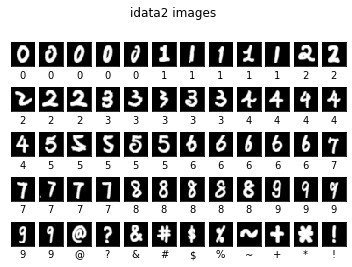

In [24]:
import warnings
warnings.filterwarnings('ignore')
for i in range(60):
    l5_plot = plt.subplot(5, 12, i + 1)
    l5_plot.imshow(X2[i], interpolation='nearest',
                   cmap=plt.cm.gray)
    l5_plot.set_xticks(())
    l5_plot.set_yticks(())
    l5_plot.set_xlabel('%s' % (y2[i]))
plt.suptitle('idata2 images')
plt.show()

In [25]:
#reshaping the array into flattened 784 array as an input for prediciton by the logistic regression classifier
X2 = X2.reshape(X2.shape[0], 784)
X2 = X2 / 255.
#data standardiation with the training set statistics is required for this clasifier
X2 = scaler.transform(X2)

y2_pred = clf.predict(X2)

score2 = clf.score(X2, y2)

print("Test score with L1 penalty: %.4f" % score2)
print("y_predicted_values", y2_pred)
print("y_labels", y2)

Test score with L1 penalty: 0.5000
y_predicted_values ['0' '0' '0' '8' '8' '2' '1' '1' '1' '1' '2' '2' '6' '2' '2' '3' '2' '9'
 '2' '6' '4' '4' '9' '4' '4' '5' '2' '3' '0' '3' '6' '6' '6' '6' '6' '7'
 '7' '1' '1' '7' '3' '8' '8' '8' '8' '8' '1' '9' '3' '1' '8' '8' '6' '4'
 '8' '8' '4' '9' '8' '1']
y_labels ['0' '0' '0' '0' '0' '1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '3' '3' '3'
 '3' '3' '4' '4' '4' '4' '4' '5' '5' '5' '5' '5' '6' '6' '6' '6' '6' '7'
 '7' '7' '7' '7' '8' '8' '8' '8' '8' '9' '9' '9' '9' '9' '@' '?' '&' '#'
 '$' '%' '~' '+' '*' '!']


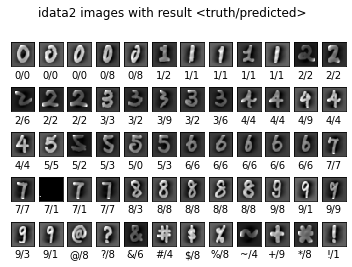

In [26]:
import warnings
warnings.filterwarnings('ignore')
for i in range(60):
    l6_plot = plt.subplot(5, 12, i + 1)
    l6_plot.imshow(X2[i].reshape(28,28), interpolation='nearest',
                        cmap=plt.cm.gray)
    l6_plot.set_xticks(())
    l6_plot.set_yticks(())
    l6_plot.set_xlabel('%s/%i' % (str(y2[i]),int(y2_pred[i])))
plt.suptitle('idata2 images with result <truth/predicted>')
plt.show()

When using a thicker version of the characters, the test score is improved, specifically it's improved by 0.05 here.\
Specifically from the results with errors, we can see that results for 8 has strongly improved, 3, 7, 6, 9 has light improvement. But some others can be hurt from thickening slightly such as 0, 1. This explains why there are improvement but not so much.

## Part B, Section 3

In [12]:
#Importing required libraries


import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import time

### Dataset loading and preprocessing:

In [13]:
#Load the MNIST dataset here
#2.  read the NMIST dataset
memory = Memory(get_data_home())
@memory.cache()
def fetch_mnist():
    content = urlopen(
        'https://www.openml.org/data/download/52667/mnist_784.arff').read()
    data, meta = loadarff(io.StringIO(content.decode('utf8')))
    data = data.view([('pixels', '<f8', 784), ('class', '|S1')])
    return data['pixels'], data['class']
X, y = fetch_mnist()
print(X.shape)

(70000, 784)


In [14]:
# rescale the data, use the traditional train/test split
X = X / 255.
###### NEW  Refromat the the labels to be string rather than byte arrays
y_trans = []
for i in range(len(y)):
    y_trans.append(y[i].decode("utf-8"))
y = np.asarray(y_trans)

### 3.1 K-NN model

In [15]:
# KNN Example KNN evelauation fucntion: Trains, Tests and prints results.
#Use a similar function when you need to explore different hyperparameter settings

def KNN(train_features, train_labels, test_features, test_labels, k):
    knn = KNeighborsClassifier(n_neighbors=k)
    start_time = time.time()
    knn.fit(train_features,train_labels)
    train_time = time.time() - start_time
    start_time = time.time()
    
    print(k)
    
    print(f'Training time {train_time} seconds for {k}NN')
    #Evaluate the result
    score = knn.score(test_features,test_labels)
    test_time = time.time() - start_time
    print(f'Test time {test_time} seconds')
    print(f'Test score with {k}NN is: {score}')
    
    y_predict = knn.predict(test_features)
    cfm = confusion_matrix(test_labels, y_predict)
    plot_confusion_matrix(cfm, classes=range(10), title='Confusion matrix for MNIST with KNN')

#### K=1 With Full Dataset

1
Training time 16.051352739334106 seconds for 1NN
Test time 1131.9232625961304 seconds
Test score with 1NN is: 0.9691
Confusion matrix, without normalization


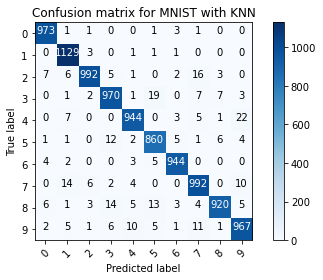

In [14]:
# Extract first 30000 images as training set and the last 5000 images as test set
X_train0, X_test0 = X[:60000], X[60000:]
y_train0, y_test0 = y[:60000], y[60000:]

KNN(X_train0, y_train0, X_test0, y_test0, 1)

#### K=1 With Partial Dataset

1
Training time 8.363002300262451 seconds for 1NN
Test time 155.65993475914001 seconds
Test score with 1NN is: 0.9805
Confusion matrix, without normalization


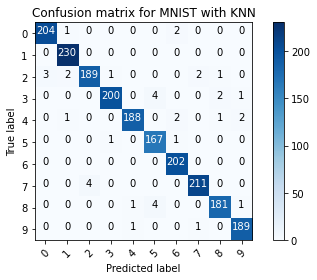

In [15]:
# Extract first 40000 images as training set and the last 2000 images as test set
X_train1, X_test1 = X[:40000], X[68000:]
y_train1, y_test1 = y[:40000], y[68000:]

KNN(X_train1, y_train1, X_test1, y_test1, 1)

1
Training time 8.554685354232788 seconds for 1NN
Test time 168.88869166374207 seconds
Test score with 1NN is: 0.9695
Confusion matrix, without normalization


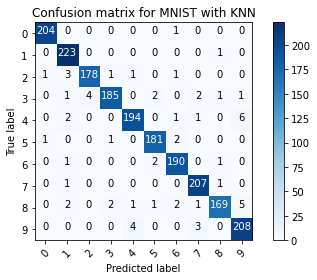

In [16]:
# Extract middle 40000 images as training set and the 2000 in the early images as test set
X_train2, X_test2 = X[20000:60000], X[10000:12000]
y_train2, y_test2 = y[20000:60000], y[10000:12000]

KNN(X_train2, y_train2, X_test2, y_test2, 1)

#### K=3 With Partial Dataset

3
Training time 10.330956935882568 seconds for 3NN
Test time 87.27759194374084 seconds
Test score with 3NN is: 0.973
Confusion matrix, without normalization


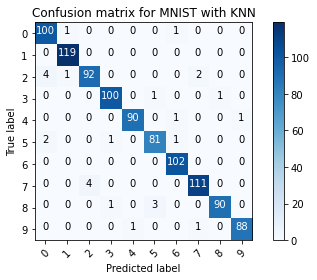

In [17]:
# Extract first 40000 images as training set and the last 1000 images as test set
X_train3, X_test3 = X[:40000], X[69000:]
y_train3, y_test3 = y[:40000], y[69000:]

KNN(X_train3, y_train3, X_test3, y_test3, 3)

3
Training time 10.232955932617188 seconds for 3NN
Test time 85.6503176689148 seconds
Test score with 3NN is: 0.979
Confusion matrix, without normalization


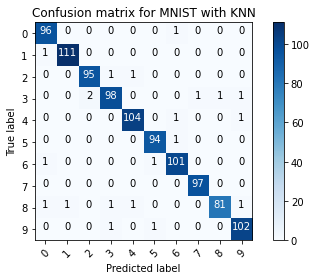

In [18]:
# Extract middle 40000 images as training set and the 1000 in the early images as test set
X_train4, X_test4 = X[20000:60000], X[10000:11000]
y_train4, y_test4 = y[20000:60000], y[10000:11000]

KNN(X_train4, y_train4, X_test4, y_test4, 3)

#### K=5 With Partial Dataset

5
Training time 10.035351991653442 seconds for 5NN
Test time 41.62321662902832 seconds
Test score with 5NN is: 0.952
Confusion matrix, without normalization


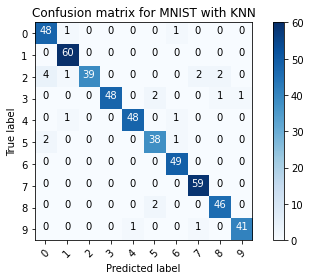

In [19]:
# Extract first 40000 images as training set and the last 500 images as test set
X_train5, X_test5 = X[:40000], X[69500:]
y_train5, y_test5 = y[:40000], y[69500:]

KNN(X_train5, y_train5, X_test5, y_test5, 5)

5
Training time 9.130083560943604 seconds for 5NN
Test time 40.28609299659729 seconds
Test score with 5NN is: 0.976
Confusion matrix, without normalization


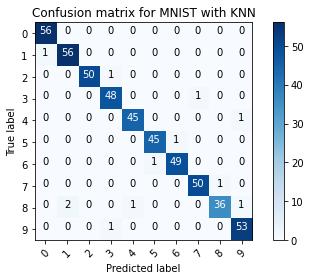

In [20]:
# Extract middle 40000 images as training set and the 500 in the early images as test set
X_train6, X_test6 = X[20000:60000], X[10000:10500]
y_train6, y_test6 = y[20000:60000], y[10000:10500]

KNN(X_train6, y_train6, X_test6, y_test6, 5)

#### KNN With PCA, n_component = 20

In [21]:
pca = PCA(n_components=20)
pca.fit(X_train0)
X_tr20 = pca.transform(X_train0)
X_te20 = pca.transform(X_test0)

1
Training time 0.2938532829284668 seconds for 1NN
Test time 7.463156223297119 seconds
Test score with 1NN is: 0.9638
Confusion matrix, without normalization


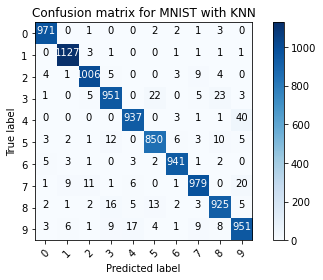

In [22]:
KNN(X_tr20, y_train0, X_te20, y_test0, 1)

3
Training time 0.224015474319458 seconds for 3NN
Test time 8.890968799591064 seconds
Test score with 3NN is: 0.9688
Confusion matrix, without normalization


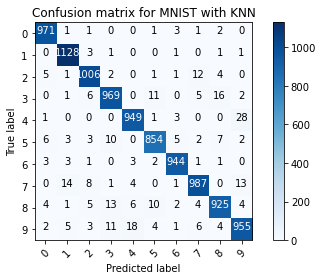

In [23]:
KNN(X_tr20, y_train0, X_te20, y_test0, 3)

5
Training time 0.26677727699279785 seconds for 5NN
Test time 10.2993004322052 seconds
Test score with 5NN is: 0.9698
Confusion matrix, without normalization


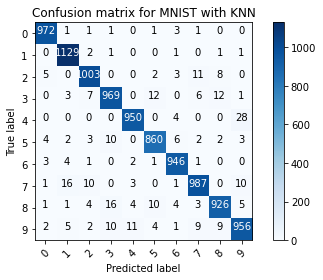

In [24]:
KNN(X_tr20, y_train0, X_te20, y_test0, 5)

In [25]:
pca = PCA(n_components=40)
pca.fit(X_train0)
X_tr40 = pca.transform(X_train0)
X_te40 = pca.transform(X_test0)

#### PCA n_componnet=40

1
Training time 0.4786491394042969 seconds for 1NN
Test time 30.47132134437561 seconds
Test score with 1NN is: 0.9735
Confusion matrix, without normalization


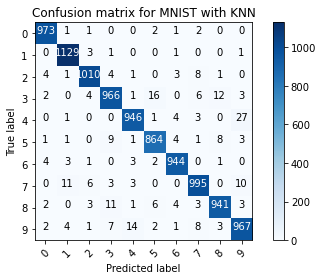

In [26]:
KNN(X_tr40, y_train0, X_te40, y_test0, 1)

3
Training time 0.3576846122741699 seconds for 3NN
Test time 33.05727410316467 seconds
Test score with 3NN is: 0.9746
Confusion matrix, without normalization


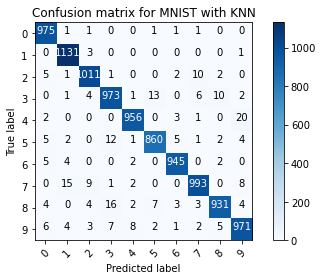

In [27]:
KNN(X_tr40, y_train0, X_te40, y_test0, 3)

5
Training time 0.3449594974517822 seconds for 5NN
Test time 34.4169237613678 seconds
Test score with 5NN is: 0.9747
Confusion matrix, without normalization


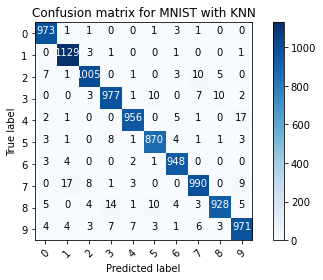

In [28]:
KNN(X_tr40, y_train0, X_te40, y_test0, 5)

**Discussion**

In the above tests, we have run the full MNIST set on KNN classifier with K=1 for one time, then used two different partial set of MNIST on KNN classifier with K=1, K=3, and K=5, and lastly used PCA to reduce the dimension of MNIST and run the reduced MNIST set on KNN classifier with K=1, K=3 and K=5 with parameter n_components set to 20 and 40. From the results (details of training time, testing time, testing scores are listed in the table below and printed in above with confusion matrix under each trained model), we can see that KNN has high computation cost, the testing time is generally very long. 

In the first method of using partial dataset, we extracted two different partial set for each K set as commented above, they have the same size for training set and test set and thus approximately the same training time and test time. However, by comparing the results of K=1, we can see that when we reduce the size of the training set by a factor of 1.5, the training time is almost halved, and when we reduced the size of the test set by a factor of 5, the testing time is almost 1/7 compared to that of fullset while not compromising the performance. Similarly, when we reduce the size of training set and testing set in K=3, K=5, the training time and testing time would be reduced correspondingly but not in a linear relationship. 

Also, we can see that choosing K=1, K=3 and K=5 does not make much difference on the performance on this particular model as they basically have the same accuracy in testing. Therefore, if it's in real application, I'd probably choose K=1 to save computational cost.


In the second method of using PCA to reduce the dimension and maximize the variance, we can see that training time and testing time is significantly reduced even though it is still running on full set. We can see that when we choose n=20, the training time is reduced by a factor of 53, and testing time is reduced by a factor of 150, when we choose n=40, the training time is reduced by a factor of 40 and the testing time is reduced by a factor of 34. Another interesting observation is that when we increase K, the training time does not increase but is relatively the same, the testing time may increase, but is by a small amount instead of linearly scaled. Also, by comparing the test score, we can see that when we choose a slightly higher number of components, it has a better performance. Though the improvement is not very high, only about 0.5%, it suggests that appropriately increasing the dimension may help improve the result. However, it remains a consideration that how high the number of components can go, because if we assume a overcomplicated model (dimension) for PCA, it is likely to result in overfitting.

<table>
  <tr>
    <th>Data</th>
    <th>K</th>
    <th>Training Time</th>
    <th>Test Time</th>
    <th>Test Score</th>
  </tr>
  <tr>
    <td>Full</td>
    <td>1</td>
    <td>16.05</td>
    <td>1131.92</td>
    <td>96.91</td>
  </tr>
  <tr>
    <td>Partial_1</td>
    <td>1</td>
    <td>8.36</td>
    <td>155.66</td>
    <td>98.05</td>
  </tr>
  <tr>
    <td>Partial_2</td>
    <td>1</td>
    <td>8.55</td>
    <td>168.89</td>
    <td>96.95</td>
  </tr>
  <tr>
    <td>Partial_1</td>
    <td>3</td>
    <td>10.33</td>
    <td>87.28</td>
    <td>97.3</td>
  </tr>
  <tr>
    <td>Partial_2</td>
    <td>3</td>
    <td>10.23</td>
    <td>85.65</td>
    <td>97.9</td>
  </tr>
  <tr>
    <td>Partial_1</td>
    <td>5</td>
    <td>10.04</td>
    <td>41.62</td>
    <td>95.2</td>
  </tr>
  <tr>
    <td>Partial_2</td>
    <td>5</td>
    <td>9.13</td>
    <td>40.29</td>
    <td>97.6</td>
  </tr>
  <tr>
    <td>PCA_n=20</td>
    <td>1</td>
    <td>0.29</td>
    <td>7.46</td>
    <td>96.38</td>
  </tr>
  <tr>
    <td>PCA_n=20</td>
    <td>3</td>
    <td>0.22</td>
    <td>8.89</td>
    <td>96.88</td>
  </tr>
  <tr>
    <td>PCA_n=20</td>
    <td>5</td>
    <td>0.27</td>
    <td>10.30</td>
    <td>96.98</td>
  </tr>
  <tr>
    <td>PCA_n=40</td>
    <td>1</td>
    <td>0.48</td>
    <td>30.47</td>
    <td>97.35</td>
  </tr>
  <tr>
    <td>PCA_n=40</td>
    <td>3</td>
    <td>0.36</td>
    <td>30.47</td>
    <td>97.35</td>
  </tr>
  <tr>
    <td>PCA_n=40</td>
    <td>5</td>
    <td>0.35</td>
    <td>34.42</td>
    <td>97.47</td>
  </tr>
</table>




### 3.2 Multi Layer Perceptron 

In [32]:
X_train7, X_test7 = X[:60000], X[65000:]
y_train7, y_test7 = y[:60000], y[65000:]

#### Multi Layer Perceptron With 1-hidden Layer

Training time 80.021 seconds
Test time 0.044 seconds
Test score with 1 hidden-layer MLP is: 0.9826
Confusion matrix, without normalization


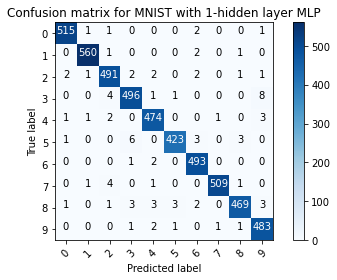

In [33]:
start_time = time.time()
mpl1 = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4, solver='sgd', verbose=False, tol=1e-4, random_state=1, learning_rate_init=.1)

#Train the classifier
mpl1.fit(X_train7,y_train7)
train_time_mlp1 = time.time() - start_time
print("Training time %.3f seconds" % train_time_mlp1)

#Evaluate the result
start_time = time.time()
score_mlp1 = mpl1.score(X_test7,y_test7)
test_time_mlp1 = time.time() - start_time
print("Test time %.3f seconds" % test_time_mlp1)
print("Test score with 1 hidden-layer MLP is: %.4f" % score_mlp1)

#Confusion Matrix
y_pr1 = mpl1.predict(X_test7)
cfm = confusion_matrix(y_test7, y_pr1)
plot_confusion_matrix(cfm, classes=range(10), title='Confusion matrix for MNIST with 1-hidden layer MLP')

#### Multi Layer Perceptron With 2 hidden Layers

Training time 80.293 seconds
Test time 0.051 seconds
Test score with 1 hidden-layer MLP is: 0.9832
Confusion matrix, without normalization


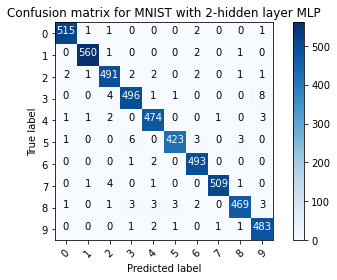

In [34]:
start_time = time.time()
mpl2 = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=100, alpha=1e-4, solver='sgd', verbose=False, tol=1e-4, random_state=1, learning_rate_init=.1)

#Train the classifier
mpl2.fit(X_train7,y_train7)
train_time_mlp2 = time.time() - start_time
print("Training time %.3f seconds" % train_time_mlp2)

#Evaluate the result
start_time = time.time()
score_mlp2 = mpl2.score(X_test7,y_test7)
test_time_mlp2 = time.time() - start_time
print("Test time %.3f seconds" % test_time_mlp2)
print("Test score with 1 hidden-layer MLP is: %.4f" % score_mlp2)

#Confusion Matrix
y_pr2 = mpl2.predict(X_test7)
cfm = confusion_matrix(y_test7, y_pr1)
plot_confusion_matrix(cfm, classes=range(10), title='Confusion matrix for MNIST with 2-hidden layer MLP')

**Discussion**


From the multilayer perceptron results shown above, we can see that it is quite different from KNN algorithm. It takes longer time to train then to test and it is super fast in testing. This makes sense because the perceptron algorithm means to update the weight based on each training data until weight converges and testing is simply seeing if the wTx is positive or negative (on which side of the plane), indicating a complex training process but rather simple testing process.

As we can see in the table below, using 1 layer and 2 layer does not necessarily improve the performance here. It might in more complicated situations. Also, the training time is approximately the same for 1 layer and 2 layer as well. However, it seems that using 2 layer perceptron would increase the testing time slightly as the calculation in testing process is slightly more complicated(two weights rather than 1). 

<table>
  <tr>
    <th>Data</th>
    <th>Training Time</th>
    <th>Test Time</th>
    <th>Test Score</th>
  </tr>
  <tr>
    <th>Multi-layer Perceptron with 1 hidden layer</th>
    <th>80.021</th>
    <th>0.044</th>
    <th>98.26</th>
  </tr>
  <tr>
    <th>Multi-layer Perception with 2 hidden layer</th>
    <th>80.293</th>
    <th>0.051</th>
    <th>98.32</th>
  </tr>
</table>

### 3.3 Support Vector Classifier

In [16]:
#SVC model
X_train7, X_test7 = X[:40000], X[67000:]
y_train7, y_test7 = y[:40000], y[67000:]

Training time 315.633 seconds
Test time 33.907 seconds
Test score with Linear SVM is: 0.9610
Confusion matrix, without normalization


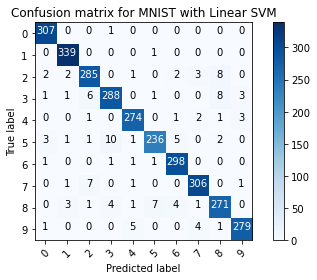

In [17]:
## Linear Support-Vector Machine

start_time = time.time()
svml = SVC(kernel = 'linear', C = 1)

#Train the classifier
svml.fit(X_train7,y_train7)
train_time_svml = time.time() - start_time
print("Training time %.3f seconds" % train_time_svml)

#Evaluate the result
start_time = time.time()
score_svml = svml.score(X_test7,y_test7)
test_time_svml = time.time() - start_time
print("Test time %.3f seconds" % test_time_svml)
print("Test score with Linear SVM is: %.4f" % score_svml)

#Confusion Matrix
y_pr_svm1 = svml.predict(X_test7)
cfm = confusion_matrix(y_test7, y_pr_svm1)
plot_confusion_matrix(cfm, classes=range(10), title='Confusion matrix for MNIST with Linear SVM')

Training time 373.317 seconds
Test time 45.028 seconds
Test score with Linear SVM is: 0.9893
Confusion matrix, without normalization


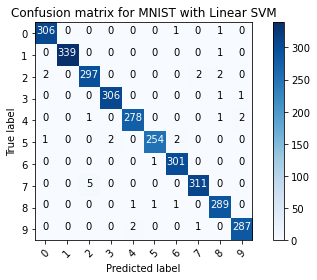

In [19]:
## Radial Basis Support-Vector Machine

start_time = time.time()
svmr = SVC(kernel = 'rbf', C = 1)

#Train the classifier
svmr.fit(X_train7,y_train7)
train_time_svmr = time.time() - start_time
print("Training time %.3f seconds" % train_time_svmr)

#Evaluate the result
start_time = time.time()
score_svmr = svmr.score(X_test7,y_test7)
test_time_svmr = time.time() - start_time
print("Test time %.3f seconds" % test_time_svmr)
print("Test score with Linear SVM is: %.4f" % score_svmr)

#Confusion Matrix
y_pr_svmr = svmr.predict(X_test7)
cfm = confusion_matrix(y_test7, y_pr_svmr)
plot_confusion_matrix(cfm, classes=range(10), title='Confusion matrix for MNIST with Linear SVM')

**Discussion**

Similar to perceptron, we can see that the the training time for SVC is much higher than its testing time as well. Overall, SVC seems to save more time and effort compared to KNN algorithm but still cost more time than multilayer perceptron.

From the results listed in the table below, we can see that the linear SVC predict results less accurately than radial SVC by more than 2.5%. However, we do have to admit that the training and testing of radial SVC takes a longer time than linear SVC as well. So it is really up to the situation and the user whether this compensation is worth it.

<table>
  <tr>
    <th>Data</th>
    <th>Training Time</th>
    <th>Test Time</th>
    <th>Test Score</th>
  </tr>
  <tr>
    <th>Linear SVC</th>
    <th>315.63</th>
    <th>33.91</th>
    <th>96.10</th>
  </tr>
  <tr>
    <th>Radial SVC</th>
    <th>371.49</th>
    <th>45.96</th>
    <th>98.93</th>
  </tr>
</table>

### 3.4 Summary

From the results of the above classifiers, we can see that the performance is basically about the same, ranging from 96% to closer to 99%. However, it is true that using KNN (partial data method) and SVC would take longer time in prediction. Multilayer perceptron algorithm and KNN implemented with PCA algorithm seems to be the optimal choice for MNIST classification as they not only give accurate prediction but also have fast training and testing process. I would consider using these two methods in real application. 